In [ ]:
import pandas as pd
import numpy as np
import math as ma
import pyvo as pvy
import astropy as ast
import matplotlib.pyplot as plt
from astroquery.utils.tap.core import TapPlus
from collections import Counter
from scipy.stats import epps_singleton_2samp as es2

pvy.tablesearch?

In [23]:
CG2020clsts = pd.read_csv("/Users/karljaehnig/Desktop/GRAD/sc_gal_sim/GaiaDR2OpenClusters/cantat_gaudin_2020_cluster_catalog.csv")
CG2020membs = pd.read_csv("/Users/karljaehnig/Desktop/GRAD/sc_gal_sim/GaiaDR2OpenClusters/cantat_gaudin_2020_member_catalog.csv")
print(CG2020clsts.sort_values('N',ascending=False).head())
CG2020clsts.loc[CG2020clsts.Cluster=='Melotte_20']

      Unnamed: 0        Cluster  RA_ICRS  DE_ICRS     GLON   GLAT    r50  \
1017        1017       NGC_7789   -0.666   56.726  115.527 -5.366  0.211   
1268        1268     Trumpler_5   99.126    9.465  202.814  1.021  0.134   
814          814       NGC_2477  118.046  -38.537  253.571 -5.838  0.150   
858          858       NGC_3532  166.417  -58.707  289.554  1.390  0.536   
271          271  Collinder_261  189.519  -68.377  301.696 -5.537  0.108   

         N    pmRA  s_pmRA  ...  dmode95  dmode_01  dmode-01       X       Y  \
1017  3019  -0.922   0.140  ...   2079.1    1718.2    2617.9  -890.1  1863.9   
1268  2267  -0.590   0.191  ...   3215.9    2419.8    4689.9 -2942.2 -1237.7   
814   1918  -2.449   0.169  ...   1442.6    1259.5    1683.6  -405.5 -1375.0   
858   1889 -10.385   0.396  ...    477.6     455.6     501.3   159.7  -449.7   
271   1858  -6.351   0.165  ...   2918.7    2250.2    4092.0  1518.5 -2459.1   

          Z      Rgc           SimbadName  _RA.icrs  _DE.icrs 

,Unnamed: 0,Cluster,RA_ICRS,DE_ICRS,GLON,GLAT,r50,N,pmRA,s_pmRA,...,dmode95,dmode_01,dmode-01,X,Y,Z,Rgc,SimbadName,_RA.icrs,_DE.icrs
697,697,Melotte_20,51.617,48.975,147.357,-6.404,2.027,764,22.864,1.127,...,175.6,172.5,178.7,-146.9,94.1,-19.6,8487.4,b'Cl Melotte 20',51.6168,48.9751


In [6]:
max_rec = 50000
clst_name = 'NGC_7789'
clstqry = CG2020clsts.loc[CG2020clsts.Cluster == clst_name]
membqry = CG2020membs.loc[CG2020membs.Cluster == clst_name]
print(clstqry)
tap_url = "http://dc.zah.uni-heidelberg.de/tap"
tap_oc_query = f"select top {int(2*clstqry.N.squeeze())} \
            * \
            FROM gedr3mock.main WHERE popid = 11 AND \
            1 = CONTAINS(\
             POINT({clstqry.RA_ICRS.squeeze()}, {clstqry.DE_ICRS.squeeze()}), \
             CIRCLE(gedr3mock.main.ra, gedr3mock.main.dec, {1.*clstqry.r50.squeeze()}))"
tap_fs_query = f"select top {max_rec} \
            * \
            FROM gedr3mock.main WHERE popid != 11 AND \
            1 = CONTAINS(\
             POINT({clstqry.RA_ICRS.squeeze()}, {clstqry.DE_ICRS.squeeze()}), \
             CIRCLE(gedr3mock.main.ra, gedr3mock.main.dec, {1.*clstqry.r50.squeeze()}))"


      Unnamed: 0   Cluster  RA_ICRS  DE_ICRS     GLON   GLAT    r50     N  \
1017        1017  NGC_7789   -0.666   56.726  115.527 -5.366  0.211  3019   

       pmRA  s_pmRA  ...  dmode95  dmode_01  dmode-01      X       Y      Z  \
1017 -0.922    0.14  ...   2079.1    1718.2    2617.9 -890.1  1863.9 -194.0   

         Rgc   SimbadName  _RA.icrs  _DE.icrs  
1017  9416.4  b'NGC 7789'   359.334    56.726  

[1 rows x 31 columns]


In [7]:
pvy_ts = pvy.tablesearch(url=tap_url, query=tap_oc_query,maxrec=max_rec)
pvy_fs = pvy.tablesearch(url=tap_url,query = tap_fs_query, maxrec=max_rec)
clsts = pvy_ts.to_table()
flds = pvy_fs.to_table()
print(len(clsts),'/',max_rec, len(flds),'/',max_rec)


638 / 50000 6246 / 50000


In [8]:
def add_obs_err_to_mock(clstdat,plx_factor=1.1):
    clst = clstdat.copy()
    
    columns = [
     'ra','dec',
        'pmra','pmdec',
        'parallax'
    ]
    
    for col in columns:
        tru_col,tru_col_err = clst[col],clst[col+'_error']
        
        if col=='parallax':
            tru_col_err = 10**((np.log10(tru_col_err) + 1)*plx_factor)
            
        obs_col = np.random.normal(loc=tru_col,
                                   scale=tru_col_err,
                                   size=(1000,tru_col.shape[0])
                                  )
        clst[col+'_error'] = obs_col.std(axis=0)
        clst[col] = obs_col.mean(axis=0)
        
    return clst

clsts1 = add_obs_err_to_mock(clsts, plx_factor=1.8)

Counter({6: 2215, 5: 1313, 4: 1040, 7: 673, 3: 427, 2: 351, 1: 218, 0: 9}) Counter({11: 638})
3646


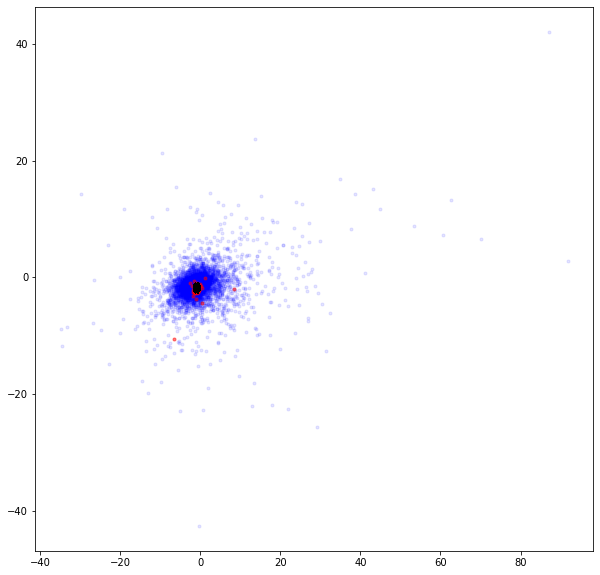

In [9]:
# clsts = clsts.to_table()
fig, axes = plt.subplots(figsize=(10,10))
axes.plot(clsts['pmra'],clsts['pmdec'],marker='.',color='red',alpha=0.5,ls='None');
axes.plot(flds['pmra'],flds['pmdec'],marker='.',color='blue',alpha=0.1,ls='None',zorder=-1);
print(Counter(flds['popid']),Counter(clsts['popid']))
# axes.set_xlim(-25,50)
# axes.set_ylim(-75,25)

axes.plot(membqry.pmRA, membqry.pmDE, marker=',',color='black',ls='None')
print(membqry.shape[0])

Epps_Singleton_2sampResult(statistic=5727.584801196625, pvalue=0.0)

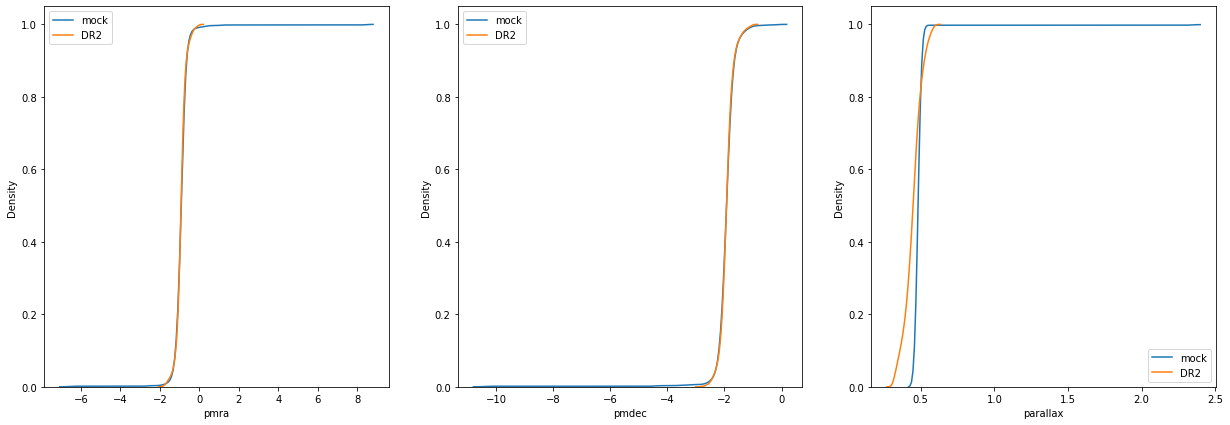

In [10]:
import seaborn as sns
fig,axes = plt.subplots(1,3,figsize=(21,7))

sns.kdeplot(clsts['pmra'],ax=axes[0],label='mock',cumulative=True)
sns.kdeplot(membqry['pmRA'],ax=axes[0],label='DR2', cumulative=True)
axes[0].legend()

sns.kdeplot(clsts['pmdec'],ax=axes[1],label='mock',cumulative=True)
sns.kdeplot(membqry['pmDE'],ax=axes[1],label='DR2', cumulative=True)
axes[1].legend()

sns.kdeplot(clsts['parallax'],ax=axes[2],label='mock',cumulative=True)
sns.kdeplot(membqry['Plx'],ax=axes[2],label='DR2', cumulative=True)
axes[2].legend()

es2(clsts['parallax'], membqry['Plx'])

Epps_Singleton_2sampResult(statistic=412.74579030654627, pvalue=4.8993945130101926e-88)

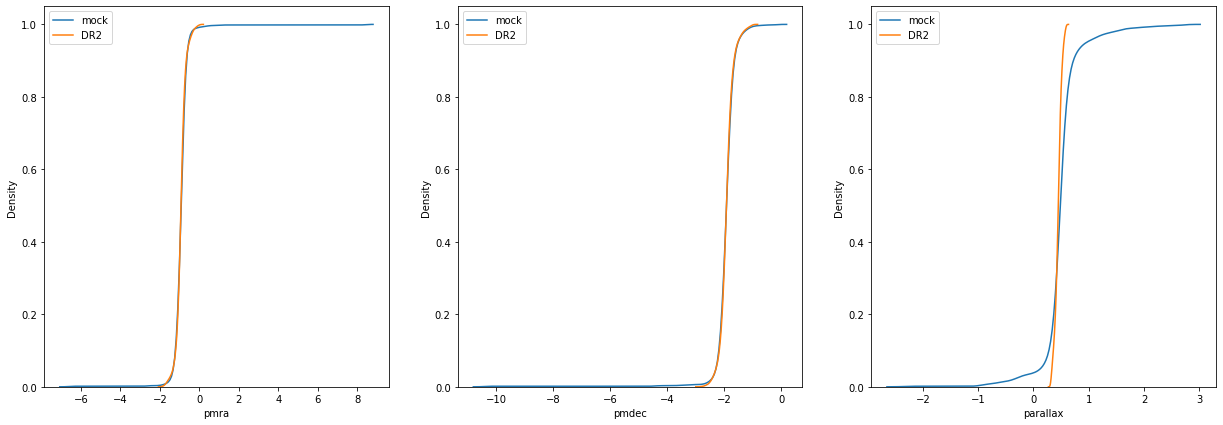

In [11]:
fig,axes = plt.subplots(1,3,figsize=(21,7))

sns.kdeplot(clsts1['pmra'],ax=axes[0],label='mock',cumulative=True)
sns.kdeplot(membqry['pmRA'],ax=axes[0],label='DR2', cumulative=True)
axes[0].legend()

sns.kdeplot(clsts1['pmdec'],ax=axes[1],label='mock',cumulative=True)
sns.kdeplot(membqry['pmDE'],ax=axes[1],label='DR2', cumulative=True)
axes[1].legend()

sns.kdeplot(clsts1['parallax'],ax=axes[2],label='mock',cumulative=True)
sns.kdeplot(membqry['Plx'],ax=axes[2],label='DR2', cumulative=True)
axes[2].legend()

es2(clsts1['parallax'],membqry['Plx'])

In [12]:
clsts.create_query?

Object `clsts.create_query` not found.


In [13]:
es2vals = []
for ii in [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,1.9,2.0]:
    ith_clst = add_obs_err_to_mock(clsts, plx_factor=ii)
    es2_ = es2(ith_clst['parallax'], membqry['Plx'])
    print(es2_[0], ii)
    es2vals.append(es2_[0])
    

423.4438446997161 1.1
492.04299759695465 1.2
427.48409859621734 1.3
542.401059097755 1.4
325.5818099713183 1.5
507.091501812947 1.6
447.4916961902826 1.7
424.7916104570249 1.8
440.87862190775303 1.9
522.6353798548014 2.0


In [14]:
columns = [
    'ra',
    'dec',
    'parallax',
    'pmra',
    'pmdec',
]

error_columns = [
    'ra_error',
    'dec_error',
    'parallax_error',
    'pmra_error',
    'pmdec_error',
]

corr_map = {
    'ra_dec_corr': [0, 1],
    'ra_parallax_corr': [0, 2],
    'ra_pmra_corr': [0, 3],
    'ra_pmdec_corr': [0, 4],
    'dec_parallax_corr': [1, 2],
    'dec_pmra_corr': [1, 3],
    'dec_pmdec_corr': [1, 4],
    'parallax_pmra_corr': [2, 3],
    'parallax_pmdec_corr': [2, 4],
    'pmra_pmdec_corr': [3, 4]
}

In [15]:
def assemble_gaia_covariance_matrix(df):

    X = df[columns].fillna(0.0).to_numpy(dtype=np.float32)
    C = np.zeros((len(df), 5, 5), dtype=np.float32)
    diag = np.arange(5)
    C[:, diag, diag] = df[error_columns].fillna(1e6).to_numpy(
        dtype=np.float32
    )

    for column, (i, j) in corr_map.items():
        C[:, i, j] = df[column].fillna(0).to_numpy(dtype=np.float32)
        C[:, i, j] *= (C[:, i, i] * C[:, j, j])
        C[:, j, i] = C[:, i, j]

    C[:, diag, diag] = C[:, diag, diag]**2

    return X, C

In [16]:
X,C = assemble_gaia_covariance_matrix(fov_:=ast.table.vstack([clsts,flds]).to_pandas())

In [17]:
X[0],C[0]

(array([359.1073    ,  56.563923  ,   0.48219597,  -0.88761437,
         -1.9578319 ], dtype=float32),
 array([[0.19279234, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.16485026, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.29283285, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.3584015 , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.28343815]],
       dtype=float32))

In [18]:
from tqdm import tqdm
def bootstrap_synthetic_covariance_matrix(X,C):
    
    X_cp = np.zeros_like(X)
    C_cp = np.zeros_like(C)
    for i_s in tqdm(range(X.shape[0])):
        synth_draws = np.random.multivariate_normal(mean=X[i_s], cov=C[i_s], size=1000)
        X_cp[i_s] = synth_draws.mean(axis=0)
        C_cp[i_s,:,:] = np.cov(synth_draws.T) 
    return (X_cp, C_cp)

In [19]:
Xcp,Ccp = bootstrap_synthetic_covariance_matrix(X,C)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6884/6884 [00:02<00:00, 2860.60it/s]


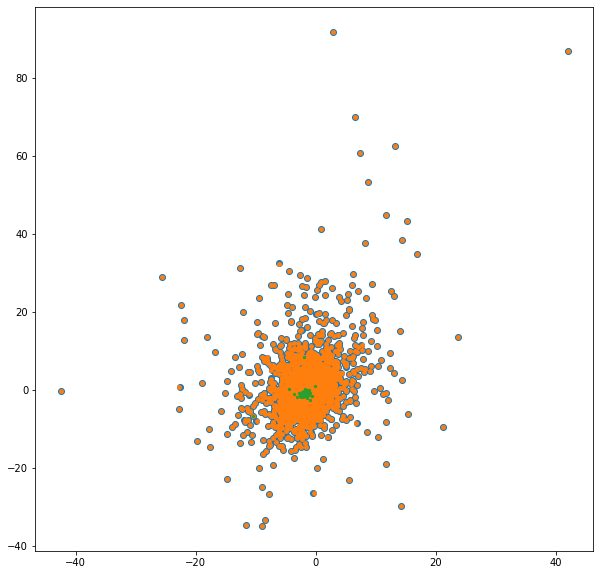

In [20]:
fig,axes = plt.subplots(figsize=(10,10))
axes.scatter(Xcp[:,4],Xcp[:,3])
axes.scatter(X[:,4],X[:,3],s=15)
axes.scatter(Xcp[:,4][fov_['popid']==11],Xcp[:,3][fov_['popid']==11],s=5)

In [22]:
from XDGMM.xdgmm.xdgmm_nsnm import XDGMM
xdmod = xdgmm_nsnm.XDGMM(tol=1e-6, method='Bovy', n_iter=10**9, n_components=2, random_state=666)

xdmod.fit(Xcp, Ccp)

AttributeError: 'XDGMM' object has no attribute 'filename'

AttributeError: 'XDGMM' object has no attribute 'filename'

In [443]:
import astroML